## Dataset Link : https://drive.google.com/file/d/1WFNusct_rM3kgLvL1AGYCQ4carHEPVLq/view?usp=share_link

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps   
import shutil

from functorch import vmap
from functools import partial

from typing import Tuple, Iterable

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [2]:
### Helper Functions

def Split_to_Train_Test(root, train_ratio=0.8):

    # Set up paths
    source_dir = os.path.join(root, "all_data")
    train_dir = os.path.join(root, "train")
    test_dir = os.path.join(root, "test")

    if os.path.exists(train_dir):
        return
        
    # create fresh train and test directories
    os.makedirs(train_dir)
    os.makedirs(test_dir)

    # Set up train and test subdirectories
    subdirectories = [os.path.basename(f.path) for f in os.scandir(source_dir) if f.is_dir()]
    
    for sub_dir in subdirectories:
        os.makedirs(os.path.join(train_dir, sub_dir), exist_ok=True)
        os.makedirs(os.path.join(test_dir, sub_dir), exist_ok=True)
    
    # splitting the data
    for sub_dir in subdirectories:
        images = os.listdir(os.path.join(source_dir, sub_dir))
        num_images = len(images)
        num_train = int(num_images * train_ratio)
        train_images = random.sample(images, num_train)
        for image in images:
            source_path = os.path.join(source_dir, sub_dir, image)
            if image in train_images:
                dest_path = os.path.join(train_dir, sub_dir, image)
            else:
                dest_path = os.path.join(test_dir, sub_dir, image)
            with Image.open(source_path) as img:
                img.save(dest_path)


# Showing images
def imshow(img, text=None):
    
    npimg = img.numpy()
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.axis("off")
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

# Plotting data
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

    
def show_la_plot(loss_list,  accuracy_list):
    
    fig, ax1 = plt.subplots()

    # create a subplot for the current key
    # ax = fig.add_subplot(len(data1), 1, i+1)

    color = 'tab:green'
    ax1.set_xlabel('epoch',color=color)
    
    color = 'tab:red'
    ax1.plot(loss_list,color=color)
    ax1.set_ylabel('total loss',color=color)
    ax1.tick_params(axis='y', color=color)
        
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  
    ax2.plot( accuracy_list, color=color)
    ax2.tick_params(axis='y', color=color)

    ax1.set_title("loss vs acc")

    fig.tight_layout()

    
    # show the figure
    plt.show()
    
    
# visualizing one batch of data    
def visualize_images(pair_dataset, num_pairs):
    
    print("\n\nvisualising ", num_pairs, " data samples from the dataset\n")
    
    # Create a simple dataloader just for simple visualization
    vis_dataloader = DataLoader(pair_dataset, shuffle=True, batch_size=num_pairs)

    # Extract one batch
    example_batch = next(iter(vis_dataloader))

    concatenated = torch.cat((example_batch[0], example_batch[1]),0)

    imshow(torchvision.utils.make_grid(concatenated, nrow=num_pairs))
    
    print(example_batch[2].numpy().reshape(-1))
    print("\n0: same class\n1: different class")
        
    
# computing the accuracy
def compute_accuracy(model, data_loader, sim_threshold):
    
    correct = 0
    total = 0

    for img_q, img_s, true_label, _ in data_loader:
        
        similarity, logits = model(img_q, img_s)
        
        logits = torch.softmax(logits, dim=1)
        
        predicted_label = torch.argmax(logits, dim=-1)
        
        correct += (predicted_label == true_label).sum().item()
        total += true_label.size(0)
    
    accuracy = 100 * correct / total
    
    return accuracy


In [3]:
class PairDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            img1_tuple = random.choice(self.imageFolderDataset.imgs)

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, img0_tuple[1], img0_tuple[1]

    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [4]:
class TripletDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        
        img_anch_tuple = random.choice(self.imageFolderDataset.imgs)
               
        while True:
            #keep looping till the same class image is found
            img_pos_tuple = random.choice(self.imageFolderDataset.imgs) 
            if img_anch_tuple[1]==img_pos_tuple[1]:
                break
       
        while True:
            #keep looping till a different class image is found
            img_neg_tuple = random.choice(self.imageFolderDataset.imgs) 
            if img_anch_tuple[1]!=img_neg_tuple[1]:
                break
                
        img_anch = Image.open(img_anch_tuple[0])
        img_pos = Image.open(img_pos_tuple[0])
        img_neg = Image.open(img_neg_tuple[0])
        
        if self.should_invert:
            img_anch = PIL.ImageOps.invert(img_anch)
            img_pos = PIL.ImageOps.invert(img_pos)
            img_neg = PIL.ImageOps.invert(img_neg)

        if self.transform is not None:
            img_anch = self.transform(img_anch)
            img_pos = self.transform(img_pos)
            img_neg = self.transform(img_neg)
        
        return img_anch, img_pos, img_neg, img_anch_tuple[1]

    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [5]:
class ContrastiveLoss(torch.nn.Module):

    def __init__(self, margin=0.5):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, similarity, label):
        
        loss_contrastive = torch.mean((1-label) * torch.pow(similarity, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - similarity, min=0.0), 2))
        
        return loss_contrastive
    

In [6]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, similarity_pos, similarity_neg):
        
        losses = torch.relu(similarity_pos - similarity_neg + self.margin)
        
        return losses.mean()

In [7]:
class SiameseNetwork(nn.Module):
    def __init__(self, cnn_layers: Iterable, linear_layers, out_channels: int):
        super().__init__()
        
        # pass in a NN
        self.cnn_layers = nn.Sequential(*cnn_layers)
        self.linear_layers = nn.Sequential(*linear_layers)
        
        
        # p can be change to induced norm (i.e., p = 1, p = 2)
        self.norm_fn = vmap(
            partial(torch.norm, p = 'fro')
        )
        
        #final linear layer to get prediction representation
        self.predictor = vmap(nn.Linear(1, out_channels))
        
        
    
    def forward(self, x_query: torch.Tensor, x_support: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Forward Pass:
            arg: Query Image (any image)
                 Support Image
        
        """
                
        x_query = self.cnn_layers(x_query)        
        x_support = self.cnn_layers(x_support)
        
#         similarity = vmap(F.pairwise_distance)(x_query, x_support)[:, None]        
  
        similarity = (self.norm_fn(x_query - x_support) + 1e-8)[:, None]
        logits = self.linear_layers(x_query.view(x_query.size()[0], -1))
            
        return similarity, logits


In [8]:
cnn_layers = [
    
    nn.Conv2d(3, 32, 3),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(32, 64, 3),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(64, 8, 3),
    nn.ReLU(),
    nn.MaxPool2d(2),

]

linear_layers = [
    
    nn.Linear(32, 2)
]

model = SiameseNetwork(cnn_layers, linear_layers, 2)

In [9]:
# Hyperparametes 

batch_size = 64
learning_rate = 1e-4


In [10]:
# splitting the data into train and test

Split_to_Train_Test(root="crime_canary_dataset", train_ratio=0.8)



visualising  10  data samples from the dataset



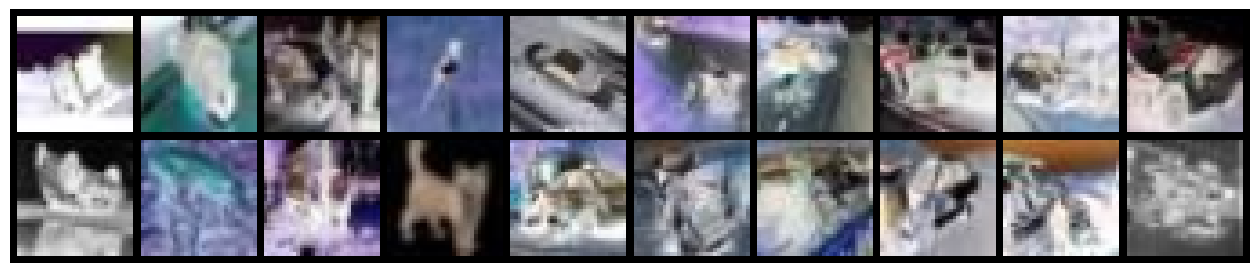

[0 1 0 1 1 0 0 0 0 0]

0: same class
1: different class


Batch Size    =  64
Train Batches =  131
Test Batches  =  33




In [11]:

## Loading Data


transformation = transforms.Compose([transforms.Resize((32, 32)),
                                     transforms.ToTensor()
                                    ])


# Load the training dataset
train_data_folder = datasets.ImageFolder(root="crime_canary_dataset/train")
test_data_folder = datasets.ImageFolder(root="crime_canary_dataset/test")

train_dataset = PairDataset(imageFolderDataset=train_data_folder, transform=transformation)
test_dataset = PairDataset(imageFolderDataset=test_data_folder, transform=transformation)

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

visualize_images(test_dataset, num_pairs=10)

print("\n")
print("Batch Size    = ", batch_size)
print("Train Batches = ", len(train_loader))
print("Test Batches  = ", len(test_loader))
print("\n")


In [12]:
# # Training

# criterion1 = ContrastiveLoss(margin = 1)
# criterion2 = nn.CrossEntropyLoss()

# optimizer = optim.Adam(model.parameters(), lr = learning_rate)

# counter = []
# loss_history = [] 
# acc_history = [] 

# tot_iteration= 0

# for epoch in range(20):
    
#     tot_loss = 0
    
#     for i, (img_q, img_s, labels) in enumerate(train_loader, 0):

#         optimizer.zero_grad()
        
#         similarity, logits = model.forward(img_q, img_s)
        
# #         loss = criterion1(similarity, labels) + criterion2(logits, labels)
#         loss = criterion1(similarity, labels)
        
#         tot_loss += loss.item()

#         loss.backward()

#         optimizer.step()
        
#         if(tot_iteration%100 == 0):
            
#             acc = compute_accuracy(model, test_loader)
#             print(f"Loss = {loss.item():.5f}  :: Acc = {acc:.5f}")
            
#             tot_iteration += 100
        
    
#     tot_loss /= len(train_loader)
    
#     accuracy = compute_accuracy(model, test_loader)
     
#     print("===================================================")
#     print(f"Epoch {epoch} :: Curr Loss = {tot_loss:.5f}  :: Curr Acc = {accuracy:.5f}")
#     print("===================================================")


In [13]:
# Training

criterion1 = ContrastiveLoss(margin=1)
criterion2 = nn.CrossEntropyLoss()
criterion3 = TripletLoss(margin=1)

optimizer = optim.Adam(model.parameters(), lr = learning_rate)

counter = []
loss_history = [] 
acc_history = [] 

tot_iteration= 0

for epoch in range(30):
    
    tot_loss = 0
    
    for i, (img_q, img_s, label_q, label_s) in enumerate(train_loader, 0):

        optimizer.zero_grad()
        
        similarity, logits = model.forward(img_q, img_s)

        loss = criterion1(similarity, torch.abs(label_q-label_s)) + criterion2(logits, label_q)
        
        tot_loss += loss.item()

        loss.backward()

        optimizer.step()
        
#         if(tot_iteration%50 == 0):
#             print(f"Loss = {loss.item():.5f}")
            
        tot_iteration += 1
        
    
    tot_loss /= len(train_loader)
    accuracy = compute_accuracy(model, test_loader, sim_threshold=1)
     
    loss_history.append(tot_loss)
    acc_history.append(accuracy)
        
#     print("\n=======================================================")
    print(f"Epoch {epoch} :: Curr Loss = {tot_loss:.5f}  :: Curr Acc = {accuracy:.5f}")
#     print("=======================================================\n")


Epoch 0 :: Curr Loss = 0.59735  :: Curr Acc = 76.66985
Epoch 1 :: Curr Loss = 0.55889  :: Curr Acc = 74.80916
Epoch 2 :: Curr Loss = 0.54312  :: Curr Acc = 76.62214
Epoch 3 :: Curr Loss = 0.55707  :: Curr Acc = 76.14504
Epoch 4 :: Curr Loss = 0.55693  :: Curr Acc = 76.00191
Epoch 5 :: Curr Loss = 0.55234  :: Curr Acc = 76.24046
Epoch 6 :: Curr Loss = 0.54817  :: Curr Acc = 75.62023
Epoch 7 :: Curr Loss = 0.55222  :: Curr Acc = 75.76336
Epoch 8 :: Curr Loss = 0.54899  :: Curr Acc = 76.00191
Epoch 9 :: Curr Loss = 0.54973  :: Curr Acc = 76.90840
Epoch 10 :: Curr Loss = 0.55061  :: Curr Acc = 75.19084
Epoch 11 :: Curr Loss = 0.56199  :: Curr Acc = 75.33397
Epoch 12 :: Curr Loss = 0.54412  :: Curr Acc = 75.81107
Epoch 13 :: Curr Loss = 0.55358  :: Curr Acc = 75.62023
Epoch 14 :: Curr Loss = 0.54157  :: Curr Acc = 76.04962
Epoch 15 :: Curr Loss = 0.54571  :: Curr Acc = 74.95229
Epoch 16 :: Curr Loss = 0.54694  :: Curr Acc = 76.62214
Epoch 17 :: Curr Loss = 0.54073  :: Curr Acc = 74.90458
Ep

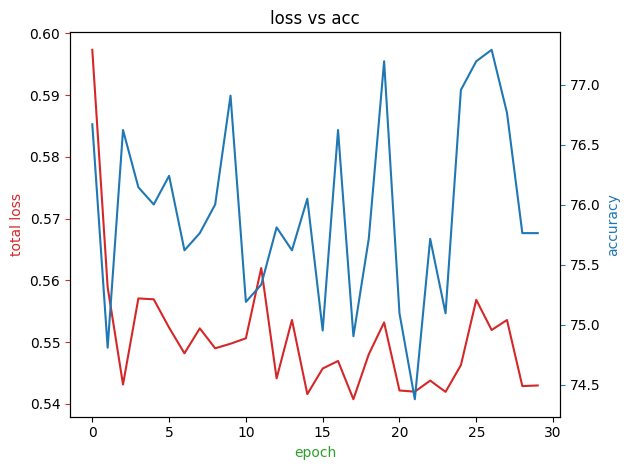

In [14]:
show_la_plot(loss_history, acc_history)